## ECG Classification Using Convolutional Neural Networks

Author: Calvin Chan 

### Introduction
For our last notebook, we will use the concept of convolution to model our ECG timeseries data. Traditionally, image analysis uses a 2D convolution to extract features from images, however since we are working with signals this would not work. Instead of 2D convolutions, we will convolve over our signals using 1D convolutions since our data only comes with one spatial dimension.

In contrast to our RNN model being implemented using TensorFlow, we will implement our CNN using **PyTorch**. This is to showcase the flexibilty of PyTorch through Object-Oriented Programming. 

### Table of Contents
1. [Data Import](#import)
2. [Data Preprocessing](#preprocessing)  
    2.1. [Binary Classification](#binary)  
    2.2. [Signal Denoising](#denoising)  
    2.3. [Train Test Split](#train_test)  
    2.4. [Scaling](#scaling)  
    2.5. [Transform to Torch Tensors](#torch)  
    2.6. [Data Loaders](#loaders)  
3. [CNN Setup and Implementation](#setup)
4. [Sample Training on One Signal](#sample_train)
5. [Training CNN Model](#training)
6. [Model Evaluation](#eval)

Here, we import all the necessary packages used in this notebook.

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import load_functions as f
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from tqdm.notebook import trange, tnrange, tqdm_notebook
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

# Autosave every minute
%autosave 60

Autosaving every 60 seconds


<a id='import'></a>
### Data Import

Below we load our full data set and only take Lead II for our model.

In [2]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [3]:
# Let's look at the data shape 
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

We also want to look at Lead II only. 

In [4]:
# Slicing only for Lead II 
X = full_data[0][:,:,1]
y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

<a id='preprocessing'></a>
### Data Preprocessing 

Below we preprocess our data, which includes transforming our column into binary, `normal` or `abnormal` classes, applying Fourier Transform signal denoising using `ecg_cleaning.py`, train test splitting our data, scaling, transforming arrays to torch tensors and finally packing them into data loaders. 

<a id='binary'></a>
#### Binary Classification

In [5]:
# Transform target column into binary classes
y = y.apply(lambda x: f.binary(x))

In [6]:
# Sanity check
y.value_counts()

diagnostic_superclass
ABNO    8645
NORM    7032
Name: count, dtype: int64

In [7]:
# Instantiate LabelEncoder 
label = LabelEncoder()

# Fit binary classes
label.fit(y)

# Transform classes
y = label.transform(y)

In [8]:
# Checking how our label is encoded
label.transform(['ABNO', 'NORM'])

array([0, 1])

As we can see, signals that are labeled `ABNO` are mapped to `0` and `NORM` are mapped `1`. 

<a id='denoising'></a>
#### Signal denoising using ecg_cleaning.py

In this following section, we denoise our ECG signals using Fourier Tranforms. We have to specify the frequencies in which we want to take out for baseline wandering and powerline interference. 

In [9]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal
signal_bl = np.apply_along_axis(c.baseline_removal, axis=1, arr=X, freq_start=0.1, freq_stop=1.5)
signal_pli = np.apply_along_axis(c.high_freq_removal, axis=1, arr=signal_bl, freq_start=40)

In [10]:
# Check shape
signal_pli.shape

(15677, 1000)

<a id='train_test'></a>
#### Train Test Split

After preprocessing our signals, we can split our data set to training and testing. We will use `20%` of our data as testing and the rest as training. Since we have a data imbalance, we will include `stratify` as well.  

In [11]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y, test_size=0.2, stratify=y)

# Checking the shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12541, 1000), (3136, 1000), (12541,), (3136,))

<a id='scaling'></a>
#### Scaling 

Next, we want to scale our data. Since we are using using a neural network, as we calculate the gradient during backpropagation, distances can affect how well this is performed. We will use `StandardScaler` for our case.

In [12]:
# Instantiate standard scaler
ss = StandardScaler()

# Fit and transform training set
X_train = ss.fit_transform(X_train)

# Transform testing set
X_test = ss.transform(X_test)

<a id='torch'></a>
#### Transforming arrays into Torch Tensors

Finally, we need to transform our NumPy arrays into torch tensors using the `torch` module.

In [13]:
# Transforming independent variables
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Transforming dependent variables
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Sanity check
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([12541, 1000]) torch.Size([3136, 1000]) torch.Size([12541]) torch.Size([3136])


<a id='loaders'></a>
#### Data Loaders

Since we want to implement batching, we will use PyTorch's `DataLoader` to do so.

In [14]:
####### Setting batch size #######

train_batch = 64
test_batch = 64

train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)

# Shuffle training set
training_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Don't shuffle validation set
testing_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False)

<a id='setup'></a>
### Model Setup and Implementation

In [15]:
class SimpleCNN(nn.Module):
    """Starting off with a simple cnn."""
    
    def __init__(self, lr=0.01):
        super(SimpleCNN, self).__init__()
        
        ##### CONVOLUTION LAYERS #####
        self.conv_layer = nn.Sequential(
            
            # Convolution block 1
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=11, padding=5), # kernel_size=21, padding=10), 
            nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=None),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout1d(0.2, inplace=True),
            
            # Convolution block 2
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=11, padding=5), # kernel_size=21, padding=10),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=None),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout1d(0.2, inplace=True),
            
            # Convolution block 3
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, padding=5), # kernel_size=21, padding=10), 
            nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=None),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout1d(0.2, inplace=True),
        )
        
        ##### FULLY-CONNECTED LAYERS #####
        self.fc_layer = nn.Sequential(
            # nn.Linear(in_features=64*250, out_features=400),
            nn.Linear(in_features=64*125, out_features=400),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=400, out_features=16),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=16, out_features=1),
        )
        
        ##### OUTPUT LAYER ##### 
        self.sigmoid = nn.Sigmoid()

        ##### LOSS FUNCTION #####
        self.binary_entropy_loss = nn.BCELoss()
        
        ##### OPTIMIZER #####
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
    def forward(self, x): 
        """Perform forward pass."""

        # Pass through convolution layers
        x = self.conv_layer(x)
        
        # Flatten the output after convolution
        x = x.view(x.size(0), -1)
        
        # Pass through fully-connected layer
        x = self.fc_layer(x)
        
        # Sigmoid output activation since we are doing binary classification
        x = self.sigmoid(x)
        
        return x

    def predict(self, x, threshold=0.5):
        """Make a binary prediction based on the sigmoid probabilities. 
        
        Note: The threshold is set to 0.5 by default.
        """
        
        # Pass data through network once
        predictions = self.forward(x)

        # Hard class prediction: Make a prediction (0 or 1) based on forward pass results
        hard_class_prediction = (predictions > threshold).numpy().astype(int).reshape(-1)

        return hard_class_prediction
    


<a id='sample_train'></a>
### Sample training on one signal

In [16]:
# Sample training 

sample = X_train[0]
sample_label = y_train[0]

print(sample.shape, sample_label.shape)

torch.Size([1000]) torch.Size([])


> **Note**: We have to add two dimensions to our data. Since we are dealing with 1 dimensional signals, the model takes an input tensor with the following format: `[batch_size, channels, signal_length]`.

We are using a batch size of 1 and since we are only using 1 Lead in our ECG signals, our channels is also 1.

In [17]:
# Using unsqueeze to add dimensions to our input signal
sample.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 1000])

In [18]:
# Initializing the model

cnn_model = SimpleCNN()
cnn_model

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv1d(1, 16, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout1d(p=0.2, inplace=True)
    (4): Conv1d(16, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout1d(p=0.2, inplace=True)
    (8): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout1d(p=0.2, inplace=True)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=8000, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4

In [19]:
# Clear any gradients from previous run (in this case this is our first and only run)
cnn_model.optimizer.zero_grad()

In [20]:
# Pass through 1 training signal to model after reshaping size
outputs = cnn_model.forward(sample.unsqueeze(0).unsqueeze(0))
# outputs = cnn_model(sample.unsqueeze(1))

In [21]:
# Output after one pass
outputs

tensor([[0.4444]], grad_fn=<SigmoidBackward0>)

In [22]:
# Convert sigmoid output to hard predictions (1s and 0s)
binary_array = (outputs > 0.5).numpy().astype(int).reshape(-1)

In [23]:
# Hard predictions
binary_array

array([0])

In [24]:
# True labels 
sample_label.numpy().astype(int).reshape(-1)

array([1])

In [25]:
# Compare hard predictions and true labels
accuracy = (binary_array == sample_label.numpy().astype(int).reshape(-1)).sum().item() / sample_label.unsqueeze(0).size(0)

# Keeping it as a tensor
# accuracy = (binary_array == sample_label).sum().item() / sample_label.unsqueeze(0).size(0)

In [26]:
# Accuracy
accuracy

0.0

In [27]:
# Compute the binary entropy loss after one training and label
# Note, we need to transform the label to a tensor of the right size as well
loss = cnn_model.binary_entropy_loss(outputs, torch.tensor([[sample_label]]))

In [28]:
# Loss
loss

tensor(0.8109, grad_fn=<BinaryCrossEntropyBackward0>)

In [29]:
# Backpropagation - computes the gradients
loss.backward()

In [30]:
# Update weights
cnn_model.optimizer.step()

### Evaluation Metrics
Let's create some function that we will use as our metrics to evaluate how well our model is doing. 

In [31]:
def get_accuracy(model, dataloader):
    """Calculate the accuracy of the model given the model itself and the data."""
    
    model.eval()
    
    correct_label = 0
    total_cases = 0
    
    # Pass through the data
    with torch.no_grad():
        for batch in dataloader:
            signal, label = batch

            # Get the prediction and compare to label
            prediction = model.predict(signal)

            # Get the number of samples in a batch
            total_cases += label.size(0)
            
            # Count the number of correctly predicted labels
            correct_label += (prediction == label.numpy().astype(int).reshape(-1)).sum().item()
        
    return (correct_label / total_cases) * 100

def get_loss(model, dataloader):
    
    model.eval()
    
    loss = 0
    
    with torch.no_grad():
        for batch in dataloader:

            # Data from first batch (32 signals)
            signal, label = batch

            # Forward pass
            output = model(signal)

            # Calculate loss
            loss += model.binary_entropy_loss(output.squeeze(1), label).item()
            
    return loss / len(dataloader)

Without any model training, let's see how accurate the model is at predicting our data set. 

In [32]:
# Testing accuracy without training
print(f"Testing accuracy without training {get_accuracy(cnn_model, testing_loader)}")
print(f"Testing loss without training {get_loss(cnn_model, testing_loader)}")

Testing accuracy without training 55.13392857142857
Testing loss without training 0.6877828264723018


<a id='training'></a>
### Training Model

In [33]:
# Instantiate model
CNN_model = SimpleCNN(lr=0.05)
CNN_model

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv1d(1, 16, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout1d(p=0.2, inplace=True)
    (4): Conv1d(16, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout1d(p=0.2, inplace=True)
    (8): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout1d(p=0.2, inplace=True)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=8000, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4

In [34]:
num_epochs = 10

training_accuracy = []
testing_accuracy = []
training_loss = []
testing_loss = []

# Loop over data 
for epoch in range(num_epochs):
    
    # Activate training model
    CNN_model.train()
    
    loss_sum = 0
    accuracy_sum = 0
    
    print(f"Training epoch: {epoch+1}")
    
    # Loop through batch in dataloader like in the function above
    for batch in training_loader:
        
        # Data from first batch (32 signals)
        inputs, labels = batch

        # Forward pass
        outputs = CNN_model(inputs)
        
        # Calculate loss
        loss = CNN_model.binary_entropy_loss(outputs.squeeze(1), labels)
        
        # Clear gradients first from previous run
        CNN_model.optimizer.zero_grad()
        
        # Backpropagation - compute the gradients
        loss.backward()
        
        # Update model parameters based on computed gradients
        CNN_model.optimizer.step()
        
        # Save loss in this batch
        loss_sum += loss.item()
        
        # After updating the model, we want to compute the accuracy
        with torch.no_grad():
            predicted = CNN_model.predict(inputs)
            accuracy_sum += (labels.numpy().astype(int).reshape(-1) == predicted).sum().item() / labels.size(0)
            
    # After the batch, we want to calculate the average training metrics
    accuracy_avg = accuracy_sum / len(training_loader)
    loss_avg = loss_sum / len(training_loader)
    
    # We will also calculate the testing metrics
    test_accuracy = get_accuracy(CNN_model, testing_loader)
    test_loss = get_loss(CNN_model, testing_loader)
    
    # Save metrics
    training_accuracy.append(accuracy_avg)
    training_loss.append(loss_avg)
    testing_accuracy.append(test_accuracy)
    testing_loss.append(test_loss)
    
    # Print results
    print(f"Train loss: {np.round(loss_avg, 3)} | "\
          f"Test loss: {np.round(test_loss, 3)} | "\
          f"Train accuracy: {np.round(accuracy_avg*100, 2)} | "\
          f"Test accuracy: {np.round(test_accuracy, 2)}")
    
print("...Training finished")

Training epoch: 1
Train loss: 0.689 | Test loss: 0.6848 | Train accuracy: 54.4621 | Test accuracy: 55.1339
Training epoch: 2
Train loss: 0.6806 | Test loss: 0.6607 | Train accuracy: 55.8834 | Test accuracy: 61.7985
Training epoch: 3
Train loss: 0.6373 | Test loss: 0.5584 | Train accuracy: 65.5454 | Test accuracy: 72.9592
Training epoch: 4
Train loss: 0.5575 | Test loss: 0.4836 | Train accuracy: 73.2315 | Test accuracy: 78.1569
Training epoch: 5
Train loss: 0.4971 | Test loss: 0.4439 | Train accuracy: 78.0143 | Test accuracy: 79.7194
Training epoch: 6
Train loss: 0.4637 | Test loss: 0.4055 | Train accuracy: 80.647 | Test accuracy: 83.227
Training epoch: 7
Train loss: 0.4326 | Test loss: 0.454 | Train accuracy: 81.9456 | Test accuracy: 79.2411
Training epoch: 8
Train loss: 0.416 | Test loss: 0.3741 | Train accuracy: 82.7038 | Test accuracy: 83.8967
Training epoch: 9
Train loss: 0.4057 | Test loss: 0.3843 | Train accuracy: 83.2642 | Test accuracy: 83.4184
Training epoch: 10
Train loss: 0.

Let's look at our model accuracy:

In [40]:
print(f"Train accuracy: {np.round(training_accuracy[-1]*100)}")
print(f"Test accuracy: {np.round(testing_accuracy[-1])}")

Train accuracy: 83.93981055536969
Test accuracy: 84.31122448979592


The result seems to be pretty good at approximately 83% accuracy without overfitting presenting. Let's see how the loss function decreased over the epochs along with the accuracy.

<a id='eval'></a>
### Model Evaluation

Below we plot the training and testing loss as the model was being trained, as well as its accuracy.

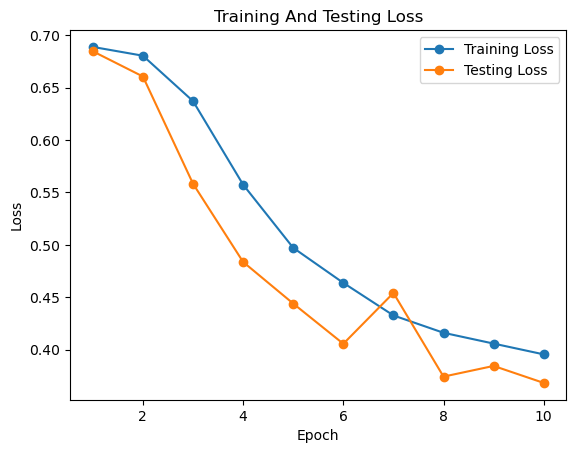

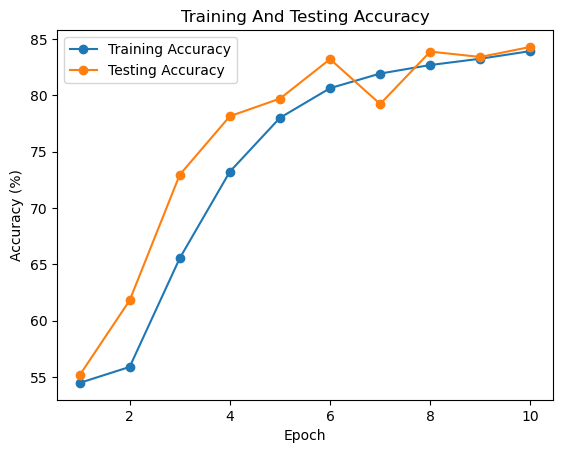

In [36]:
plt.figure()
plt.plot(range(1, len(training_loss)+1), training_loss, label="Training Loss", marker='o')
plt.plot(range(1, len(testing_loss)+1), testing_loss, label="Testing Loss", marker='o')
plt.title("Training and testing loss".title())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, len(training_accuracy)+1), np.array(training_accuracy)*100, label="Training Accuracy", marker='o')
plt.plot(range(1, len(testing_accuracy)+1), testing_accuracy, label="Testing Accuracy", marker='o')
plt.title("Training and testing accuracy".title())
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

From the plots above, we see that the training loss steadily decreases as the accuracy improves. On the other hand, the testing loss also decreases steadily except for at one epoch where it increased a little bit and then went back to decreasing. 

> **Note**: We saw a similar behaviour in our RNN model during training where the loss increases and then decreases again. The cause of this is still yet to be determined. 

We aren't stopping here though, we have to dig deeper into our results. Like how we did for our RNN model, we will look into the classification report to see how other metrics are, such as precision and recall, as well as the confusion matrix to see how our model is classifying these signals. 

In [37]:
# Make predictions 
predictions = CNN_model.predict(X_test.unsqueeze(1))

# Compute classification report
cr = classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85      1729
         1.0       0.80      0.87      0.83      1407

    accuracy                           0.84      3136
   macro avg       0.84      0.85      0.84      3136
weighted avg       0.85      0.84      0.84      3136



As a reminder, **Recall** score is defined as follows:

$$
\rm Recall = \frac{TP}{TP + FN}
$$

where  
- **TP** = True Positive
- **TN** = True Negative
- **FP** = False Positive
- **FN** = False Negative

From our classification report, we see that our recall score is actually higher for `class 1` at 87%, that is `normal` labelled ECGs. 
> **Note**: We want a model that has a higher recall for `class 0` since we are trying to identify anyone that has even the slightest possibility of having an abnormal heart rhythm, even if this means misclassifying people who are fine. This can be another goal for when we optimize our model by adjusting parameters such as the binary prediction threshold.

On the other hand, **Precision** is defined as follows:

$$
\rm Precision = \frac{TP}{TP + FP}
$$

For our situation we do not need to put as much emphasis on having a high precision since we are not as concerned with classifying precisely, rather we are more concerned about the models sensitivity in detecting abnormal ECGs. Nonetheless, our model precisely classified abnormal signals 89% of the time. 

Next, we will look into the confusion matrix.

In [38]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, predictions)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

# display(cf_df)

,Predicted Abnormal,Predicted Normal
True Abnormal,1415,314
True Normal,178,1229


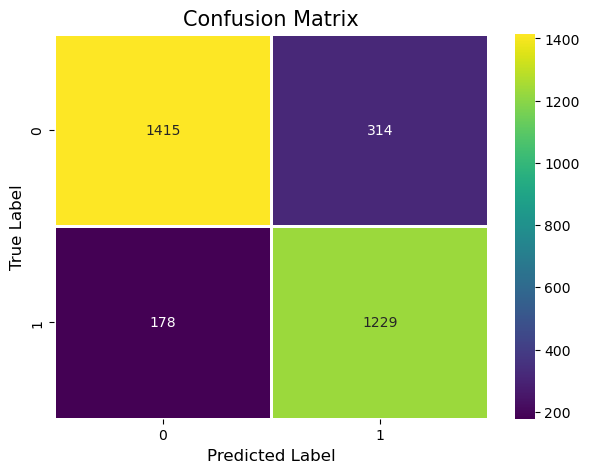

In [42]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

Looking at the confusion matrix, we see that our model seems to **predict more abnormal signals as normal** rather than the other way around. Again this is not what we are hoping for if we are to deploy this model for early detection. This can be adjusted when we hyperparameter tune our model. 

Finally, we will look at the ROC curve and AUC score. 

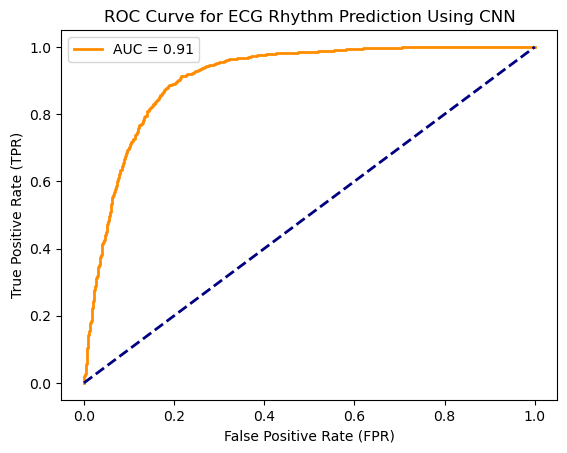

Area under curve (AUC):0.9102007108964802



In [48]:
prediction_prob = CNN_model.forward(X_test.unsqueeze(1)).detach().numpy()

fprs, tprs, thresholds = roc_curve(y_test, prediction_prob)
roc_auc = roc_auc_score(y_test, prediction_prob)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using CNN')
plt.legend(loc="best")
plt.savefig('cnn_roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC): {roc_auc}')
print()

As a reminder, the ROC Curve plots the performance of the model at various classification thresholds. We can see that our model already has a really high True Positive Rate (TPR or Recall) for a low False Positive Rate (FPR). 
>**Note**: FPR is the rate at which our model would classify an abnormal ECG signal as normal. 

On the other hand, our Area Under the Curve (AUC) score is at 0.91 which is pretty high. It can be interpreted as the probability of a random normal class being ranked higher than a random abnormal class, in terms of binary classification. 